# Домашнее задание по обработке текстов

## Предсказание цены акции по экономическим новостям

Входные данные:
* Новости о компании "Газпром", начиная с 2010 года
* Стоимость акций компании "Газпром" на ММВБ, начиная с 2010 года
    * цена открытия (Open)
    * цена закрытия (ClosingPrice)
    * максимальная цена за день (DailyHigh)
    * минимальная цена за день (DailyLow) 
    * объем бумаг (VolumePcs)


In [1]:
import pandas as pd
df = pd.read_csv('texts.csv', index_col='date', parse_dates=True) 
df = df.sort_index().reset_index() 

In [2]:
pr_all = pd.read_csv('gazprom_prices.csv', sep=';', index_col='Date', parse_dates=True) 
pr_all = pr_all.sort_index().reset_index() 

### Часть 1. Вводная

Проведите предобработку текстов: если считаете нужным, выполните токенизацию, приведение к нижнему регистру, лемматизацию и/или стемминг. Ответьте на следующие вопросы:
* Есть ли корреляция между средней длинной текста за день и ценой закрытия?
* Есть ли корреляция между количеством упоминаний Алексея Миллера  и ценой закрытия? Учтите разные варианты написания имени.
* Упоминаний какого газопровода в статьях больше: 
    * "северный поток"
    * "турецкий поток"?
* О каких санкциях пишут в статьях?

#### Токенизация, приведение к нижнему регистру, лемматизация

In [3]:
import re
from pymorphy2 import MorphAnalyzer

prog = re.compile('[А-Яа-я\-]+')
m = MorphAnalyzer()

for i in range(df.shape[0]):
    tmp = df["text"][i]
    tmp = tmp.lower()
    df['text'][i] = tmp.lower()
    tokens = prog.findall(tmp)
    t = ' '.join(tokens)
    lemmas = [m.parse(word)[0].normal_form for word in t.split()]
    t1 = ' '.join(lemmas)
    df['text'][i] = t1

C:\Users\Yana\Anaconda3\lib\site-packages\ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  # Remove the CWD from sys.path while we load stuff.
C:\Users\Yana\Anaconda3\lib\site-packages\ipykernel_launcher.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from ipykernel import kernelapp as app


In [4]:
df.head()

,date,text
0,2010-01-02,газпром не исключать в год выпуск облигация пр...
1,2010-01-19,газпром готовый забирать весь объесть азербайд...
2,2010-01-28,консорциум в глава с российский оао газпром не...
3,2010-02-07,газпромбанк открыть на кипр дочерний компания ...
4,2010-02-09,газпром вновь понизить прогноз экспорт в европ...


####  Корреляция между средней длинной текста за день и ценой закрытия

In [5]:
df['len'] = 0
df['frequency'] = 0

In [6]:
for i in range(df.shape[0]):
    tmp = df["text"][i]
    tmp = len(str(tmp))
    t1 = ''.join(str(tmp))
    df['len'][i] = t1

C:\Users\Yana\Anaconda3\lib\site-packages\ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """


In [7]:
df.head()

,date,text,len,frequency
0,2010-01-02,газпром не исключать в год выпуск облигация пр...,241,0
1,2010-01-19,газпром готовый забирать весь объесть азербайд...,410,0
2,2010-01-28,консорциум в глава с российский оао газпром не...,555,0
3,2010-02-07,газпромбанк открыть на кипр дочерний компания ...,299,0
4,2010-02-09,газпром вновь понизить прогноз экспорт в европ...,783,0


In [8]:
df1 = df.pivot_table(values='len', index='date', aggfunc='mean').reset_index() 
df1.head()

,date,len
0,2010-01-02,241
1,2010-01-19,410
2,2010-01-28,555
3,2010-02-07,299
4,2010-02-09,783


In [9]:
data = df1.merge(pr_all, how = 'outer', left_on = 'date', right_on = 'Date')
data.head()

,date,len,Date,Open,ClosingPrice,DailyHigh,DailyLow,VolumePcs
0,2010-01-02,241.0,2010-01-02,184.74,189.85,190.40,183.50,76298175.0
1,2010-01-19,410.0,2010-01-19,190.10,189.76,190.47,187.36,48626727.0
2,2010-01-28,555.0,2010-01-28,183.75,182.30,185.98,181.67,62561241.0
3,2010-02-07,299.0,2010-02-07,144.80,148.25,148.27,144.05,41766629.0
4,2010-02-09,783.0,2010-02-09,161.79,162.80,163.57,161.53,42721026.0


In [10]:
X = data.as_matrix(columns=['ClosingPrice', 'len' ])
X

array([[ 189.85,  241.  ],
       [ 189.76,  410.  ],
       [ 182.3 ,  555.  ],
       ..., 
       [ 132.15,     nan],
       [ 157.25,     nan],
       [ 125.93,     nan]])

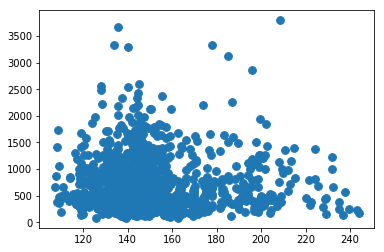

In [11]:
from matplotlib import pyplot as plt
%matplotlib inline
import seaborn as sns

plt.scatter(X[:,0],
            X[:,1],
            cmap='autumn',
            s=60);

In [12]:
import numpy
numpy.corrcoef(X[:,0], X[:,1])

array([[ nan,  nan],
       [ nan,  nan]])

In [13]:
import scipy
scipy.stats.spearmanr(X[:,0], X[:,1])

SpearmanrResult(correlation=nan, pvalue=nan)

Корреляции между средней длинной текста за день и ценой закрытия нет

#### Корреляция между количеством упоминаний Алексея Миллера и ценой закрытия

In [16]:
for i in range(df.shape[0]):
    word_list = df["text"][i].split()
    df['frequency'][i] = word_list.count('миллер')

C:\Users\Yana\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [17]:
df.head()

,date,text,len,frequency
0,2010-01-02,газпром не исключать в год выпуск облигация пр...,241,0
1,2010-01-19,газпром готовый забирать весь объесть азербайд...,410,2
2,2010-01-28,консорциум в глава с российский оао газпром не...,555,0
3,2010-02-07,газпромбанк открыть на кипр дочерний компания ...,299,0
4,2010-02-09,газпром вновь понизить прогноз экспорт в европ...,783,0


In [18]:
df2 = df.pivot_table(values='frequency', index='date', aggfunc='sum').reset_index() 
df2.head()

,date,frequency
0,2010-01-02,0
1,2010-01-19,2
2,2010-01-28,0
3,2010-02-07,0
4,2010-02-09,0


In [19]:
data1 = df2.merge(pr_all, how = 'outer', left_on = 'date', right_on = 'Date')
data1.head()

,date,frequency,Date,Open,ClosingPrice,DailyHigh,DailyLow,VolumePcs
0,2010-01-02,0.0,2010-01-02,184.74,189.85,190.40,183.50,76298175.0
1,2010-01-19,2.0,2010-01-19,190.10,189.76,190.47,187.36,48626727.0
2,2010-01-28,0.0,2010-01-28,183.75,182.30,185.98,181.67,62561241.0
3,2010-02-07,0.0,2010-02-07,144.80,148.25,148.27,144.05,41766629.0
4,2010-02-09,0.0,2010-02-09,161.79,162.80,163.57,161.53,42721026.0


In [21]:
X1 = data1.as_matrix(columns=['ClosingPrice', 'frequency' ])
X1

array([[ 189.85,    0.  ],
       [ 189.76,    2.  ],
       [ 182.3 ,    0.  ],
       ..., 
       [ 132.15,     nan],
       [ 157.25,     nan],
       [ 125.93,     nan]])

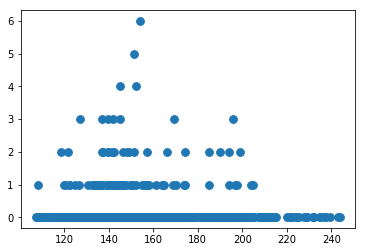

In [22]:
plt.scatter(X1[:,0],
            X1[:,1],
            cmap='autumn',
            s=60);

In [23]:
numpy.corrcoef(X1[:,0], X1[:,1])

array([[ nan,  nan],
       [ nan,  nan]])

In [24]:
scipy.stats.spearmanr(X1[:,0], X1[:,1])

SpearmanrResult(correlation=nan, pvalue=nan)

Корреляции между количеством упоминаний Алексея Миллера и ценой закрытия нет

#### Упоминаний какого газопровода в статьях больше:
* "северный поток"
* "турецкий поток"?

In [25]:
sv = tu = 0
for s in range(df.shape[0]):
    text = df["text"][s]
    i = text.find('северный поток')
    if i > -1:
        sv += 1
    else:
        i = text.find('турецкий поток')
        if i > -1:
            tu += 1
print('северный поток:', sv)
print('турецкий поток', tu)


северный поток: 12
турецкий поток 32


Упоминаний "турецкого потока" больше

#### О каких санкциях пишут в статьях

In [26]:
! cat texts.csv | docker run --rm -i inemo/syntaxnet_rus > dat.conll

In [27]:
from nltk import DependencyGraph
import codecs

In [28]:
processed_sentences = []
sentence = []
for line in codecs.open('dat.conll', 'r', 'utf-8'):
    if len(line) == 1:
        processed_sentences.append(sentence)
        sentence = []
    else:
        word = line.split("\t")
        sentence.append(word)

deps = []
res = []
for sentence in processed_sentences:
    s = u""
    for line in sentence:
        s += u"\t".join(line) + u'\n'
    deps.append(s)

for sent_dep in deps:
    graph = DependencyGraph(tree_str=sent_dep)
    tree = graph.tree()
    
    
for sent_dep in deps:    
    adjectives = {}
    for t in sent_dep.split('\n'):
        if len(t) > 1:
            splt = t.split('\t')
            if splt[1] == 'санкция':
                n = int(splt[6]) # номер слова, с которым связана санкция
                n = 0
                sent_split = sent_dep.split('\n')
                sent = [i.split('\t') for i in sent_split if len(i) > 1] 
                if sent[n-1][3] == 'ADJ':
                    adjectives[str(n)] = [sent[n-1][1]]
                    adjectives[str(n)].append('санкция')
    if adjectives:
        sent_split = sent_dep.split('\n')
        sent = [i.split('\t') for i in sent_split if len(i) > 1]
        for splt in sent:
            if splt[7] in ['amod', 'nmod']:
                if splt[6] in adjectives:
                    adjectives[splt[6]].append(splt[1])

        for t in adjectives.values():
            for elem in t:
                print(elem)
            print()

большой
санкция

англо-голландский
санкция

неясный
санкция

вэб
санкция



## Часть 2. Классификационная
Вам предстоит решить следующую задачу: по текстам новостей за день определить, вырастет или понизится цена закрытия.
Для этого:
* бинаризуйте признак "цена закрытия":  новый признак ClosingPrice_bin равен 1, если по сравнению со вчера цена не упала, и 0 – в обратном случаея;
* составьте бучающее и тестовое множество: данные до начала 2016 года используются для обучения, данные с 2016 года и позже – для тестирования.

Таким образом, в каждлый момент времени мы знаем: 
* ClosingPrice_bin – бинарый целевой признак
* слова из статей, опубликованных в этот день – объясняющие признаки

В этой части задания вам нужно сделать baseline алгоритм и попытаться его улучшить в следующей части. 

Используйте любой известный вам алгоритм классификации текстов для того, Используйте $tf-idf$ преобразование, сингулярное разложение, нормировку признакого пространства и любые другие техники обработки данных, которые вы считаете нужным. Используйте accuracy и F-measure для оценки качества классификации. Покажите, как  $tf-idf$ преобразование или сингулярное разложение или любая другая использованная вами техника влияет на качество классификации.
Если у выбранного вами алгоритма есть гиперпараметры (например, $\alpha$ в преобразовании Лапласа для метода наивного Байеса), покажите, как изменение гиперпараметра влияет на качество классификации.

In [29]:
pr_all['ClosingPrice_bin'] = 0

In [30]:
for i in range(pr_all.shape[0]):
    if pr_all['ClosingPrice'][i] >= pr_all['ClosingPrice'][i+1]:
        pr_all['ClosingPrice_bin'][i+1] = 0
    else:
        pr_all['ClosingPrice_bin'][i+1] = 1

In [32]:
pr_all.head()

,Date,Open,ClosingPrice,DailyHigh,DailyLow,VolumePcs,ClosingPrice_bin
0,2010-01-02,184.74,189.85,190.40,183.50,76298175,0
1,2010-01-03,168.70,168.20,170.71,166.33,58570262,0
2,2010-01-04,172.49,175.00,176.14,172.33,94994135,1
3,2010-01-06,158.20,159.26,160.31,154.39,67031024,0
4,2010-01-07,147.00,143.20,147.77,143.04,50067990,0


In [33]:
df = df.drop(['len','frequency'], 1)
datas = df.merge(pr_all, how = 'outer', left_on = 'date', right_on = 'Date')
datas.head()

,date,text,Date,Open,ClosingPrice,DailyHigh,DailyLow,VolumePcs,ClosingPrice_bin
0,2010-01-02,газпром не исключать в год выпуск облигация пр...,2010-01-02,184.74,189.85,190.40,183.50,76298175.0,0.0
1,2010-01-19,газпром готовый забирать весь объесть азербайд...,2010-01-19,190.10,189.76,190.47,187.36,48626727.0,0.0
2,2010-01-28,консорциум в глава с российский оао газпром не...,2010-01-28,183.75,182.30,185.98,181.67,62561241.0,1.0
3,2010-02-07,газпромбанк открыть на кипр дочерний компания ...,2010-02-07,144.80,148.25,148.27,144.05,41766629.0,0.0
4,2010-02-09,газпром вновь понизить прогноз экспорт в европ...,2010-02-09,161.79,162.80,163.57,161.53,42721026.0,0.0


In [90]:
datas1 = datas.dropna()
X_train = datas1.loc[datas['date'] < '2016-01-01']
X_test = datas1.loc[datas['date'] >= '2016-01-01']
y_train = X_train['ClosingPrice_bin']
y_test = X_test['ClosingPrice_bin']

In [91]:
X_train_d = X_train.drop(['ClosingPrice_bin'], 1)
X_test_d = X_test.drop(['ClosingPrice_bin'], 1)

In [92]:
X_train_text = X_train_d['text']
X_test_text = X_test_d['text']

Переведем документы в векторы признаков:

In [93]:
from sklearn.feature_extraction.text import CountVectorizer

count_vect = CountVectorizer()
X_train_counts = count_vect.fit_transform(X_train_text)
X_test_counts = count_vect.transform(X_test_text)

#### Мультиномиальный наивный Байес

In [94]:
from sklearn.naive_bayes import MultinomialNB
clf = MultinomialNB(alpha=0.0001).fit(X_train_counts, y_train)

In [95]:
predicted = clf.predict(X_test_counts)

In [96]:
from sklearn.metrics import *

acc = accuracy_score(predicted, y_test)
micro_f1 = f1_score(predicted, y_test, average = 'micro')
macro_f1 = f1_score(predicted, y_test, average = 'macro')
print('acc = {0:1.4f}'.format(acc))
print('micro F1 = {0:1.4f}'.format(micro_f1))
print('macro F1 = {0:1.4f}\n'.format(macro_f1))

acc = 0.5257
micro F1 = 0.5257
macro F1 = 0.5164



In [97]:
clf = MultinomialNB(alpha=1).fit(X_train_counts, y_train)
predicted = clf.predict(X_test_counts)
acc = accuracy_score(predicted, y_test)
micro_f1 = f1_score(predicted, y_test, average = 'micro')
macro_f1 = f1_score(predicted, y_test, average = 'macro')
print('acc = {0:1.4f}'.format(acc))
print('micro F1 = {0:1.4f}'.format(micro_f1))
print('macro F1 = {0:1.4f}\n'.format(macro_f1))

acc = 0.4901
micro F1 = 0.4901
macro F1 = 0.4784



При уменьшениии гиперпараметра alpha качество выросло 

#### Логистическая регрессия

In [98]:
from sklearn.linear_model import LogisticRegression
clf = LogisticRegression(penalty='l1', C=0.07).fit(X_train_counts, y_train)
predicted = clf.predict(X_test_counts)

In [99]:
acc = accuracy_score(predicted, y_test)
micro_f1 = f1_score(predicted, y_test, average = 'micro')
macro_f1 = f1_score(predicted, y_test, average = 'macro')
print('acc = {0:1.4f}'.format(acc))
print('micro F1 = {0:1.4f}'.format(micro_f1))
print('macro F1 = {0:1.4f}\n'.format(macro_f1))

acc = 0.4862
micro F1 = 0.4862
macro F1 = 0.4811



In [100]:
from sklearn.linear_model import LogisticRegression
clf = LogisticRegression(penalty='l2', C=1).fit(X_train_counts, y_train)
predicted = clf.predict(X_test_counts)

acc = accuracy_score(predicted, y_test)
micro_f1 = f1_score(predicted, y_test, average = 'micro')
macro_f1 = f1_score(predicted, y_test, average = 'macro')
print('acc = {0:1.4f}'.format(acc))
print('micro F1 = {0:1.4f}'.format(micro_f1))
print('macro F1 = {0:1.4f}\n'.format(macro_f1))

acc = 0.4506
micro F1 = 0.4506
macro F1 = 0.4428



Для лучшего результата уменьшаем коэф. регуляризации и "штрафуем" по l1

## Часть 3. Творческая
Придумайте и попытайтесь сделать еще что-нибудь, чтобы улучшить качество классификации. 
Направления развития:
* Морфологический признаки: 
    * использовать в качестве признаков только существительные или только именованные сущности;
* Модели скрытых тем:
    * использовать в качестве признаков скрытые темы;
    * использовать в качестве признаков динамические скрытые темы 
    пример тут: (https://github.com/RaRe-Technologies/gensim/blob/develop/docs/notebooks/dtm_example.ipynb)
* Синтаксические признаки:
    * использовать SOV-тройки в качестве признаков
    * кластеризовать SOV-тройки по эмбеддингам глаголов (обученные word2vec модели можно скачать отсюда: (http://rusvectores.org/ru/models/) и использовать только центроиды кластеров в качестве признаков
* что-нибудь еще     